In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'icv83551/assignments/assignment1/'
FOLDERNAME = 'icv83551/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/icv83551/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/icv83551/assignments/assignment1/icv83551/datasets
/content/drive/My Drive/icv83551/assignments/assignment1


# Softmax Classifier exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

In this exercise you will:
    
- Implement a fully-vectorized **loss function** for the Softmax classifier.
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** using numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from icv83551.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#%load_ext autoreload
#%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'icv83551/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


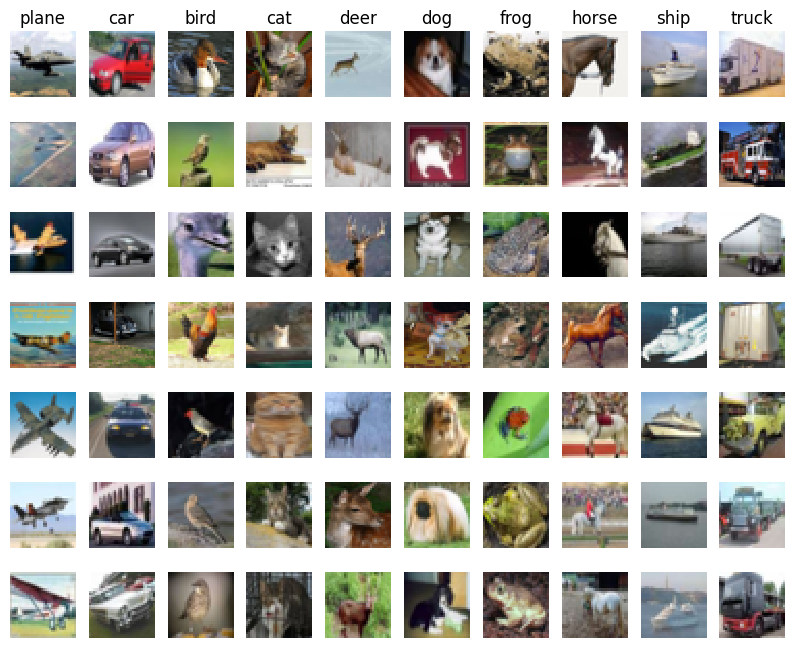

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


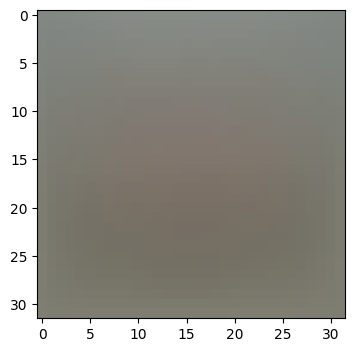

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `icv83551/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from icv83551.classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.352047
loss: 2.352047
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Because if we have the same number of examples for each class, there is 10% probability (0.1 score) to classify the sample correctly if we guess randomly. The weights initialized randomly and naive softmax turns scores into probabilities, and the probability of a correct guess is 0.1.




The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from icv83551.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.824100 analytic: 0.824100, relative error: 1.613092e-09
numerical: 0.087802 analytic: 0.087802, relative error: 3.895543e-07
numerical: 1.469102 analytic: 1.469102, relative error: 4.505513e-08
numerical: 0.228007 analytic: 0.228007, relative error: 1.984521e-07
numerical: 0.710678 analytic: 0.710678, relative error: 2.062902e-08
numerical: 0.014400 analytic: 0.014400, relative error: 2.505322e-06
numerical: 1.901800 analytic: 1.901800, relative error: 1.361942e-08
numerical: -0.785273 analytic: -0.785273, relative error: 1.047504e-07
numerical: -2.373142 analytic: -2.373142, relative error: 1.348296e-08
numerical: -2.916686 analytic: -2.916686, relative error: 2.524578e-09
numerical: 0.824146 analytic: 0.824146, relative error: 1.608028e-09
numerical: 0.461067 analytic: 0.461067, relative error: 4.441184e-08
numerical: 0.178980 analytic: 0.178980, relative error: 4.831935e-07
numerical: -2.681250 analytic: -2.681250, relative error: 2.495805e-09
numerical: 1.879327 analyt

**Inline Question 2**

Although gradcheck is reliable softmax loss, it is possible that for SVM loss, once in a while, a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a svm loss gradient check could fail? How would change the margin affect of the frequency of this happening?

Note that SVM loss for a sample $(x_i, y_i)$ is defined as: $$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$ Where $j$ iterates over all classes except the correct class $y_i$ and $s_j$ denotes the classifier score for $j^{th}$ class. $\Delta$ is a scalar margin.
*Hint: the SVM loss function is not strictly speaking differentiable.*


$\color{blue}{\textit Your Answer:}$

1. This discrepancy could be caused by the max(0,z) funciton, where z = $s_j - s_{y_i} + \Delta$. This function (Hinge Loss) is not differentiable at z = 0, so the analytical and numerical answers can be slightly different (z is less then the gradient step size).

2. It is not a reason for concern if both values are very close to each other and it isn't happening very often.

3. f(z) = max(0,z), h = 0.00001 where h is the gradient step size. let z be 0.000001. The analytical gradient is f(z)' = 1 because z>0. But the Numerical gradient will be $$\frac{f(z+h)-f(z-h)}{2h} = \frac{max(0,0.000001+0.00001) - max(0,0.000001-0.00001)}{2*0.00001} = \frac{max(0,0.000011) - max(0,-0.000009)}{0.00002} = \frac{0.000011-0}{0.00002} = 0.55$$
As we can see 1 $\neq$ 0.55.

4. The change of margin $\Delta$ won't affect the frequency of that happening, only the location because it happens when $s_j - s_{y_i} = -\Delta$, the frequency does not depend on the value.



In [10]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from icv83551.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.352047e+00 computed in 0.071032s
Vectorized loss: 2.352047e+00 computed in 0.011881s
difference: -0.000000


In [11]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.050906s
Vectorized loss and gradient: computed in 0.006796s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `icv83551/classifiers/linear_classifier.py`.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from icv83551.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 774.549019
iteration 100 / 1500: loss 284.496040
iteration 200 / 1500: loss 105.595929
iteration 300 / 1500: loss 39.879496
iteration 400 / 1500: loss 15.907653
iteration 500 / 1500: loss 7.217231
iteration 600 / 1500: loss 3.921068
iteration 700 / 1500: loss 2.776863
iteration 800 / 1500: loss 2.311333
iteration 900 / 1500: loss 2.206896
iteration 1000 / 1500: loss 2.136169
iteration 1100 / 1500: loss 2.110088
iteration 1200 / 1500: loss 2.055868
iteration 1300 / 1500: loss 2.093111
iteration 1400 / 1500: loss 2.128530
That took 5.128370s


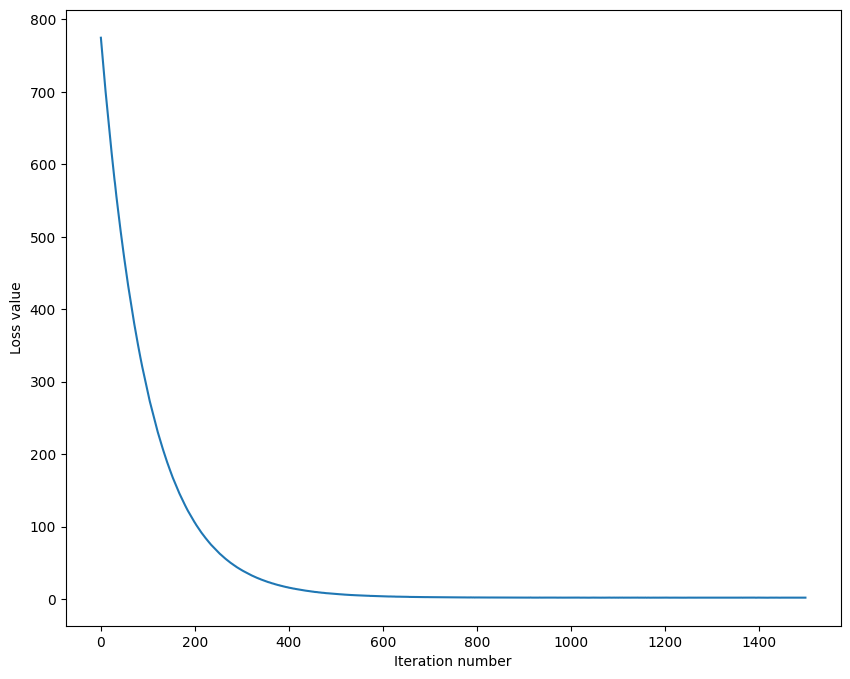

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print(y_train_pred)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

[6 8 9 ... 5 6 8]
training accuracy: 0.329265
validation accuracy: 0.351000


In [15]:
# Save the trained model for autograder.
softmax.save("softmax.npy")

softmax.npy saved.


In [46]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a Softmax on the.        #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this.   #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train; once  #
# you are confident that your validation code works, you should rerun the      #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-6, 1e-5]
regularization_strengths = [1e4, 2.5e3]

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    print(f'lr = {lr} reg = {reg}')
    # Softmax classifier
    softmax = Softmax()
    softmax.train(X_train, y_train, lr, reg, num_iters=1000)

    # Softmax predictions
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

    # Save if validation accuracy is the best
    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_softmax = softmax


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr = 1e-06 reg = 10000.0
lr = 1e-06 reg = 2500.0
lr = 1e-05 reg = 10000.0
lr = 1e-05 reg = 2500.0
lr 1.000000e-06 reg 2.500000e+03 train accuracy: 0.382102 val accuracy: 0.384000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.352612 val accuracy: 0.349000
lr 1.000000e-05 reg 2.500000e+03 train accuracy: 0.210612 val accuracy: 0.217000
lr 1.000000e-05 reg 1.000000e+04 train accuracy: 0.190673 val accuracy: 0.197000
best validation accuracy achieved during cross-validation: 0.384000


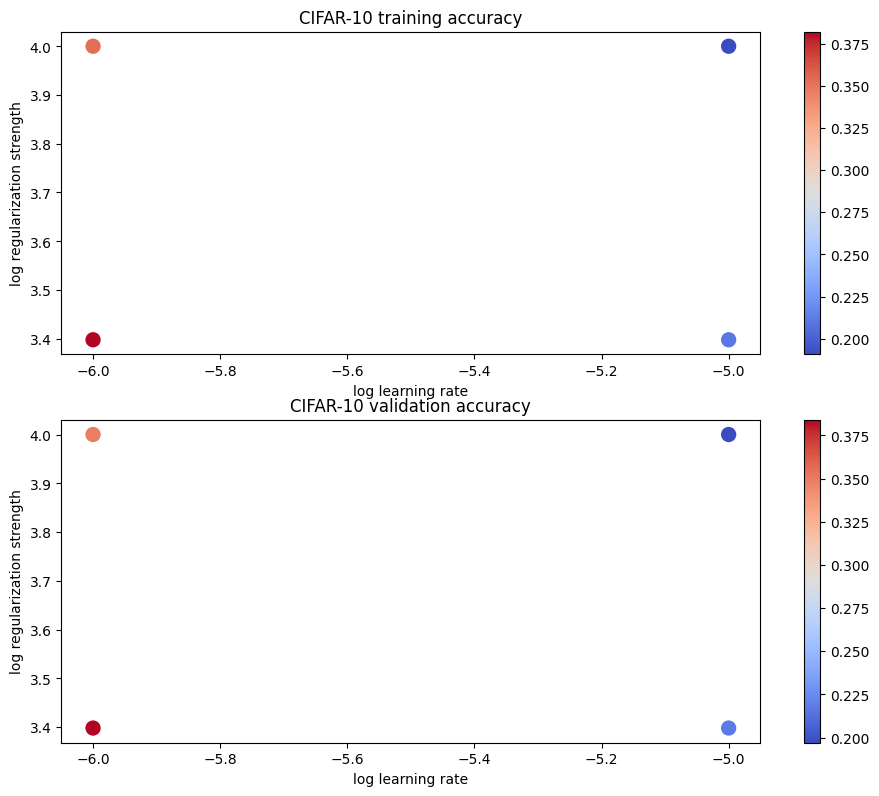

In [47]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [48]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.367000


In [49]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


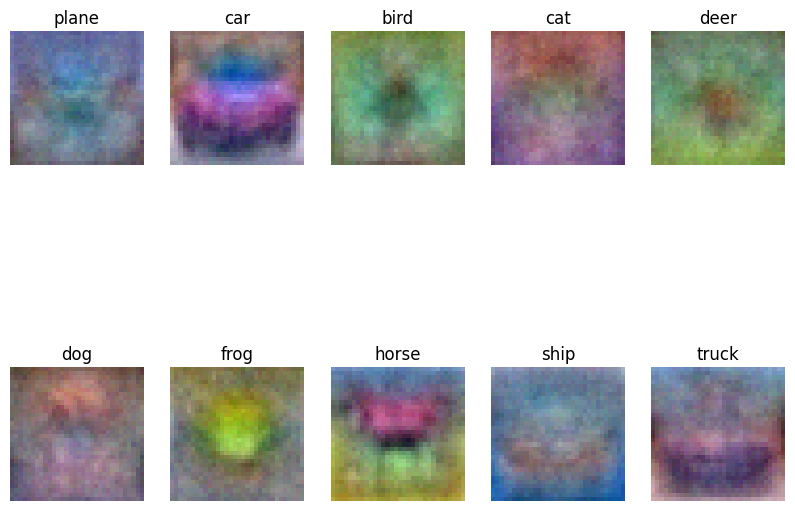

In [50]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ The visualized weights looks like a very noisy version of each class. This is because the Softmax classifier is a linear transformation and averaging of the training images. It is trying to template match, meaning the classifier checks how well the input image aligns with the weight matrix which was calculated by linear calculations and averaging of different examples (colors, background, etc..) hence a lot of noise in the process.


**Inline Question 4** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would change the softmax loss, but leave the SVM loss unchanged.

$\color{blue}{\textit Your Answer:}$
True

$\color{blue}{\textit Your Explanation:}$
It is possible because of the margin of SVM. For SVM if the new trainig point satisfy the margin $\Delta$ (meaning the correct class wins by a margin) then the loss would be 0. This is not the case for the Softmax loss, as it can never be 0 (Softmax is a probability and it can never be exactly 1 or 0, meaning there will always be loss).
